In [2]:
#Se cargan datos limpios para hacer analisis de clusters

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
df = pd.read_csv('c://users//Sergi//proyectos//proyecto_final//data//processed//vehicles_with_model_clean.csv')


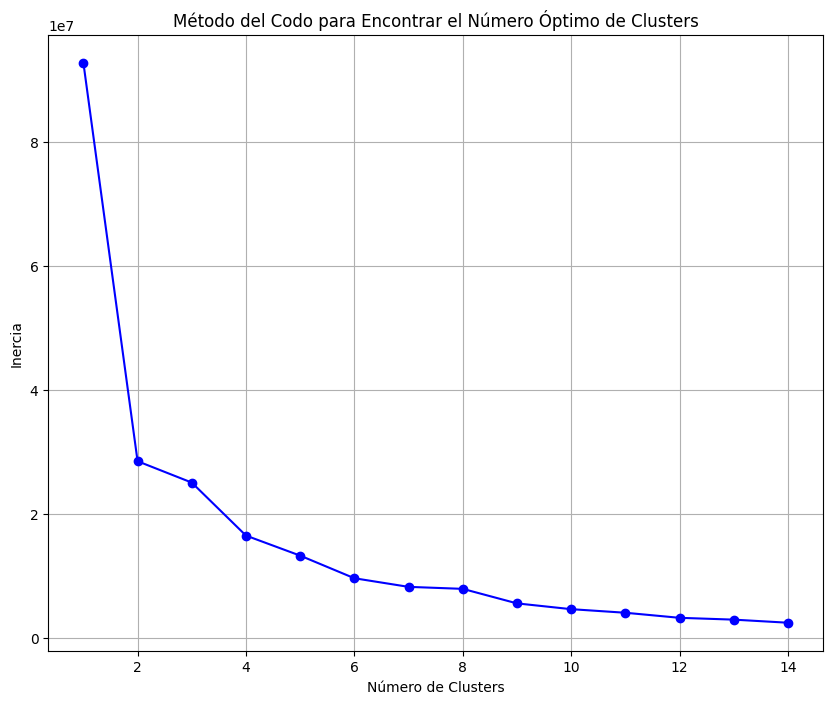

In [96]:
# Cluster basado en latitud y longitud del lugar de venta del vehiculo
# Utilizamos el metodo del codo para identificar el numero ideal de clusters

# Extraer las coordenadas de latitud y longitud
coords = df[['lat', 'long']].values

# Método del codo para determinar el número óptimo de clusters
inertia = []
K = range(1, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(coords)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(10, 8))
plt.plot(K, inertia, 'bo-')
plt.title('Método del Codo para Encontrar el Número Óptimo de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

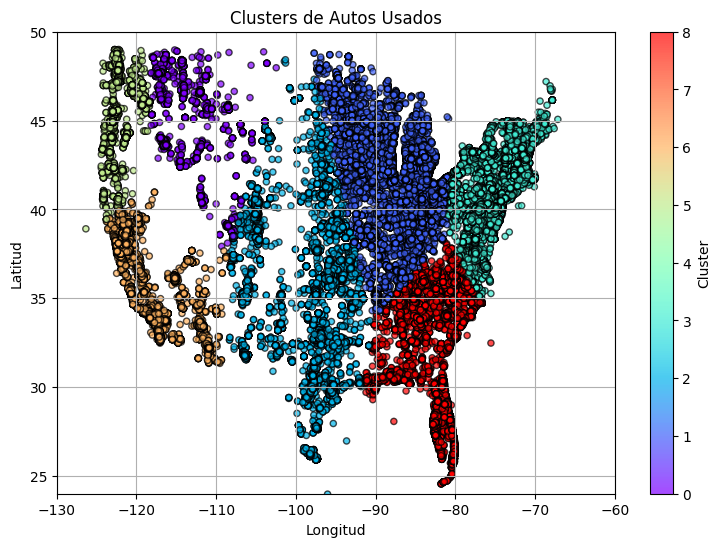

In [97]:
# Se probaron diversas opciones, y nos quedamos con 9 clusters
# Grafico con 9  clusters
# Extraer las coordenadas de latitud y longitud
coords = df[['lat', 'long']].values

# Definir el número de clusters
n_clusters = 9  # Puedes ajustar este valor según lo necesario

# Aplicar K-Means
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(coords)

# Añadir los labels de los clusters al DataFrame
df['cluster'] = kmeans.labels_

# Graficar los clusters
plt.figure(figsize=(9, 6))
plt.scatter(df['long'], df['lat'], c=df['cluster'], cmap='rainbow', marker='o', s=20, alpha=0.7, edgecolor='k')
plt.title('Clusters de Autos Usados')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.xlim(-130, -60)
plt.ylim(24, 50)
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

# Guardar los resultados en un nuevo archivo CSV
df.to_csv('c://users//Sergi//proyectos//proyecto_final//data//processed//archivo_cluster_KMeans_9.csv', index=False)


In [102]:
# Preparamos nuevo dataframe para identificar nuevos clusters
# basado en variables adicionales a las de ubicacion geografica
df2 = df[['lat', 'long', 'manufacturer', 'price']]

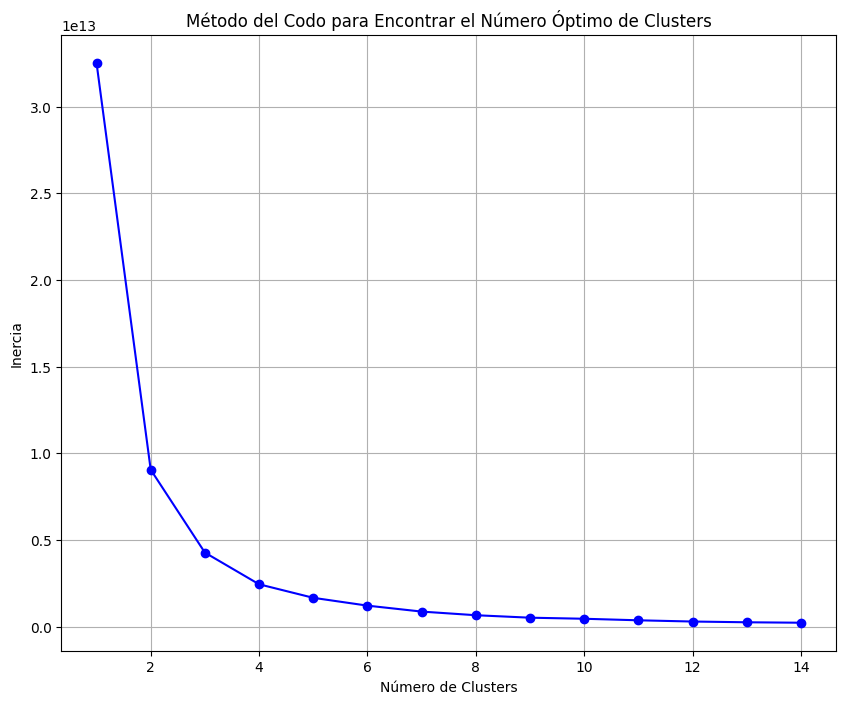

In [103]:
# Utilizamos nuevamente el metodo del codo para identificar numero ideal
# de clusters

# Convertir la columna categórica 'manufacturer' usando one-hot encoding
df_encoded = pd.get_dummies(df2[['manufacturer']])

# Combinar las columnas codificadas con las demás columnas numéricas
df1 = pd.concat([df[['lat', 'long', 'price']], df_encoded], axis=1)

# Método del codo para determinar el número óptimo de clusters
inertia = []
K = range(1, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df1)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(10, 8))
plt.plot(K, inertia, 'bo-')
plt.title('Método del Codo para Encontrar el Número Óptimo de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()


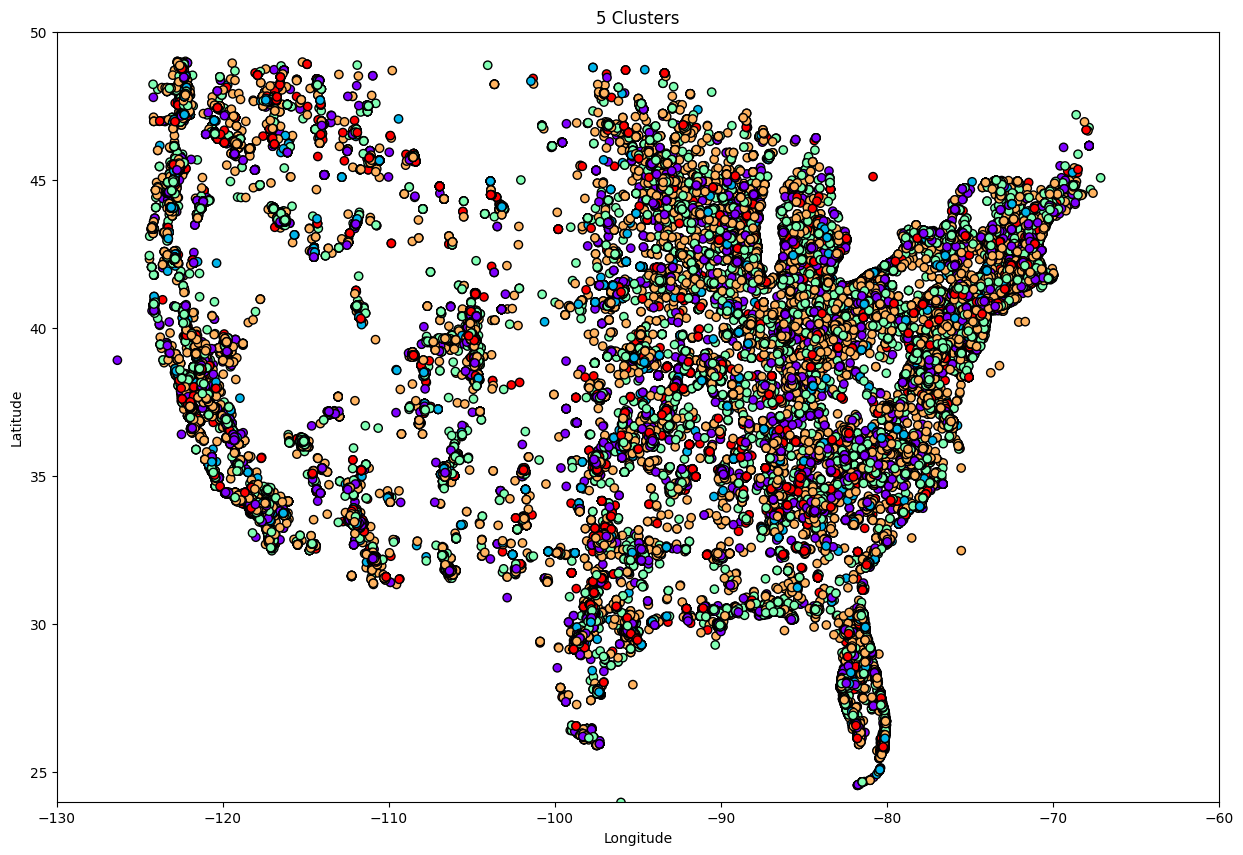

In [107]:
# Avanzaremos con un modelo basado en 5 clusters

# Dividimos df en test y training
X_train, X_test = train_test_split(df2, test_size=0.2, random_state=42)

# Procesamos informacion categorica con onehotencoder
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['manufacturer'])
    ],
    remainder='passthrough'  # Keep the remaining columns as is
)

X_train_processed = preprocessor.fit_transform(X_train)

kmeans = KMeans(n_clusters=5, random_state=42)

# Entrenamos modelo
X_train['cluster'] = kmeans.fit_predict(X_train_processed)

# Graficamos resultado
fig, ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(X_train['long'], X_train['lat'], c=X_train['cluster'], cmap='rainbow', edgecolor='black')
ax.set_xlim(-130, -60)
ax.set_ylim(24, 50)
ax.set_title('5 Clusters')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()




In [108]:
# Creamos columna cluster en el df original y asignamos informacion de clusters
df['cluster'] = np.nan  
df.loc[X_train.index, 'cluster'] = X_train['cluster']  #


# Guardamos informacion en csv
df.to_csv('c://users//Sergi//proyectos//proyecto_final//data//processed//archivo_cluster_KMeans_5.csv', index=False)



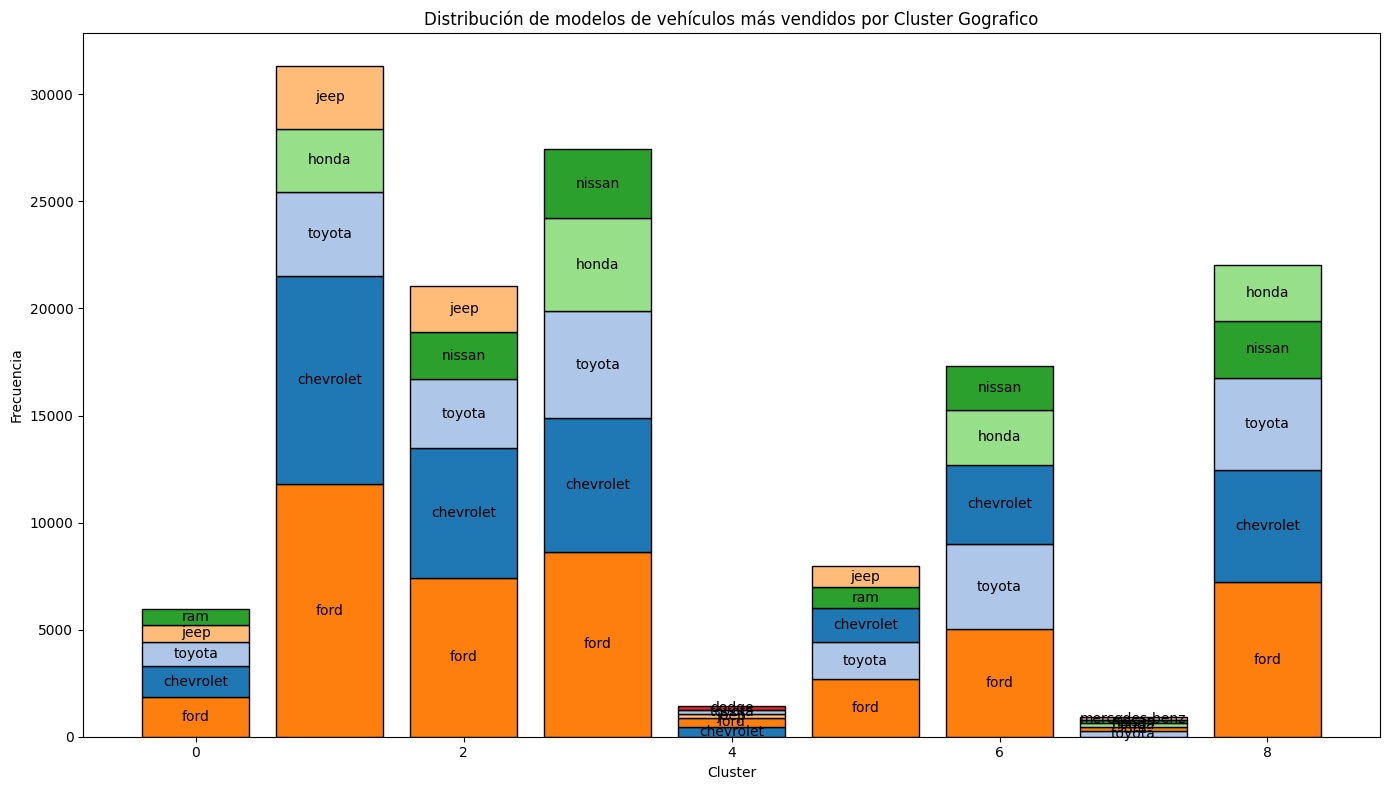

In [4]:
# Analizamos Modelos mas vendidos por Clusters geograficos
# Cargar el DataFrame con los clústeres
df_cluster_9 = pd.read_csv('c://users//Sergi//proyectos//proyecto_final//data//processed//archivo_cluster_KMeans_9.csv')

# Lista de clústeres especificados
clusters = [0, 1, 2, 3, 4, 5, 6, 7, 8]

# Calculamos las frecuencias y porcentajes por clúster y modelo
df_freq = df_cluster_9.groupby(['cluster', 'manufacturer']).size().unstack(fill_value=0)
df_percentages = df_freq.div(df_freq.sum(axis=1), axis=0) * 100

# Ordenamos los modelos por porcentaje para cada clúster
sorted_manufacturers = df_percentages.apply(lambda x: x.sort_values(ascending=False).index, axis=1)

# Creamos el gráfico
fig, ax = plt.subplots(figsize=(14, 8))

# Obtenemos una lista de todos los modelos únicos
unique_manufacturers = df_cluster_9['manufacturer'].unique()

# Definimos una paleta de colores
color_palette = plt.cm.tab20.colors  # Puedes cambiar 'tab20' a otra paleta si deseas más colores

# Creamos un diccionario para almacenar los colores asignados a cada modelo
manufacturers_colors = {manufacturer: color_palette[i % len(color_palette)] for i, manufacturer in enumerate(unique_manufacturers)}

# Dibujamos las barras apiladas
for cluster in clusters:
    bottom = 0
    for manufacturer in sorted_manufacturers[cluster][:5]:  # Iteramos con los modelos ordenados
        height = df_freq.loc[cluster, manufacturer]
        color = manufacturers_colors[manufacturer]

        ax.bar(cluster, height, bottom=bottom, width=0.8, color=color, edgecolor='black')
        ax.text(cluster, bottom + height/2, manufacturer, ha='center', va='center', fontsize=10)
        bottom += height

# Configuramos el gráfico
ax.set_xlabel('Cluster')
ax.set_ylabel('Frecuencia')
ax.set_title('Distribución de modelos de vehículos más vendidos por Cluster Gografico')

plt.xticks(rotation=0)
plt.tight_layout()

# Mostramos el gráfico
plt.show()

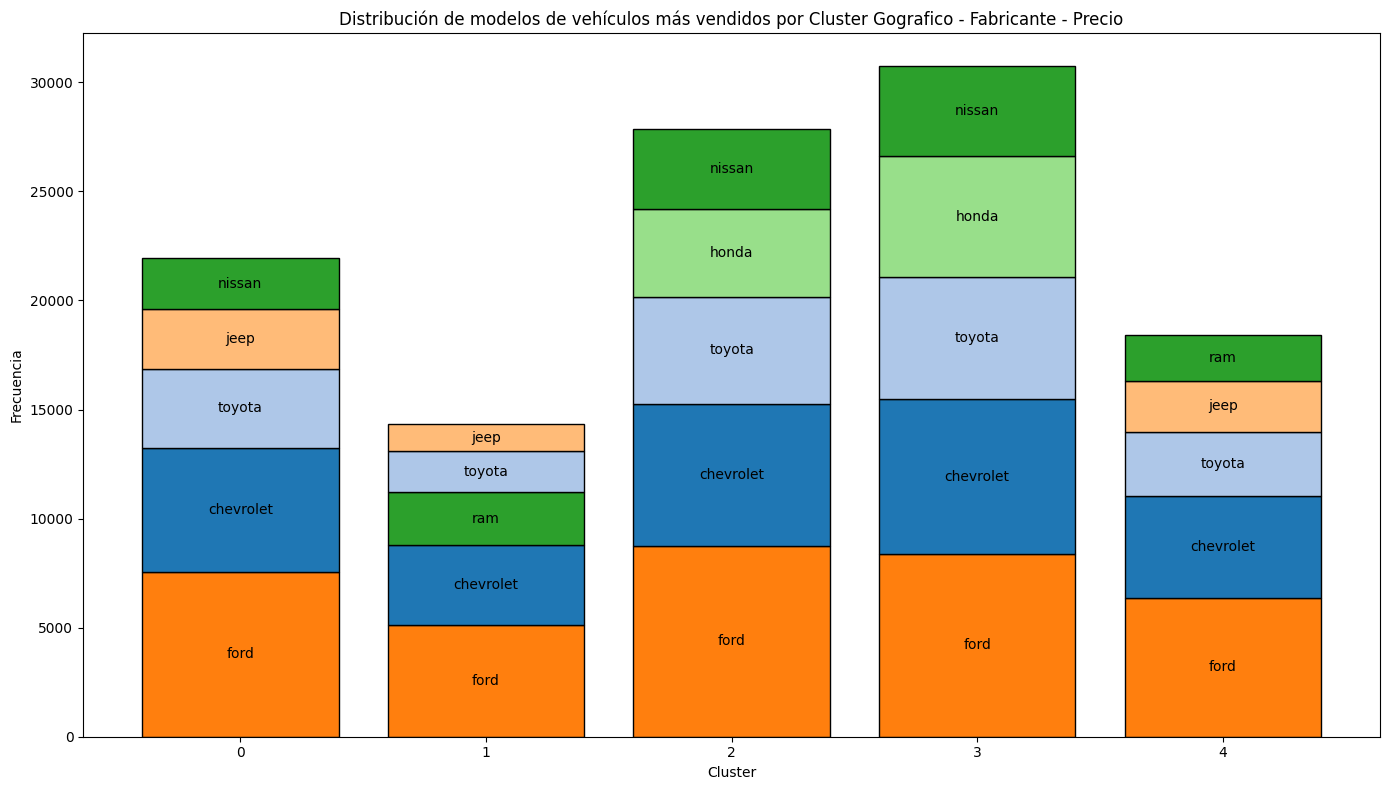

In [109]:
# Analizamos modelos mas vendidos por cluster Geograficos - Precio - Fabricante
# Cargar el DataFrame con los clústeres
df_cluster_5 = pd.read_csv('c://users//Sergi//proyectos//proyecto_final//data//processed//archivo_cluster_KMeans_5.csv')

# Lista de clústeres especificados
clusters = [0, 1, 2, 3, 4]

# Calculamos las frecuencias y porcentajes por clúster y modelo
df_freq = df_cluster_5.groupby(['cluster', 'manufacturer']).size().unstack(fill_value=0)
df_percentages = df_freq.div(df_freq.sum(axis=1), axis=0) * 100

# Ordenamos los modelos por porcentaje para cada clúster
sorted_manufacturers = df_percentages.apply(lambda x: x.sort_values(ascending=False).index, axis=1)

# Creamos el gráfico
fig, ax = plt.subplots(figsize=(14, 8))

# Obtenemos una lista de todos los modelos únicos
unique_manufacturers = df_cluster_9['manufacturer'].unique()

# Definimos una paleta de colores
color_palette = plt.cm.tab20.colors  # Puedes cambiar 'tab20' a otra paleta si deseas más colores

# Creamos un diccionario para almacenar los colores asignados a cada modelo
manufacturers_colors = {manufacturer: color_palette[i % len(color_palette)] for i, manufacturer in enumerate(unique_manufacturers)}

# Dibujamos las barras apiladas
for cluster in clusters:
    bottom = 0
    for manufacturer in sorted_manufacturers[cluster][:5]:  # Iteramos con los modelos ordenados
        height = df_freq.loc[cluster, manufacturer]
        color = manufacturers_colors[manufacturer]

        ax.bar(cluster, height, bottom=bottom, width=0.8, color=color, edgecolor='black')
        ax.text(cluster, bottom + height/2, manufacturer, ha='center', va='center', fontsize=10)
        bottom += height

# Configuramos el gráfico
ax.set_xlabel('Cluster')
ax.set_ylabel('Frecuencia')
ax.set_title('Distribución de modelos de vehículos más vendidos por Cluster Gografico - Fabricante - Precio')

plt.xticks(rotation=0)
plt.tight_layout()

# Mostramos el gráfico
plt.show()


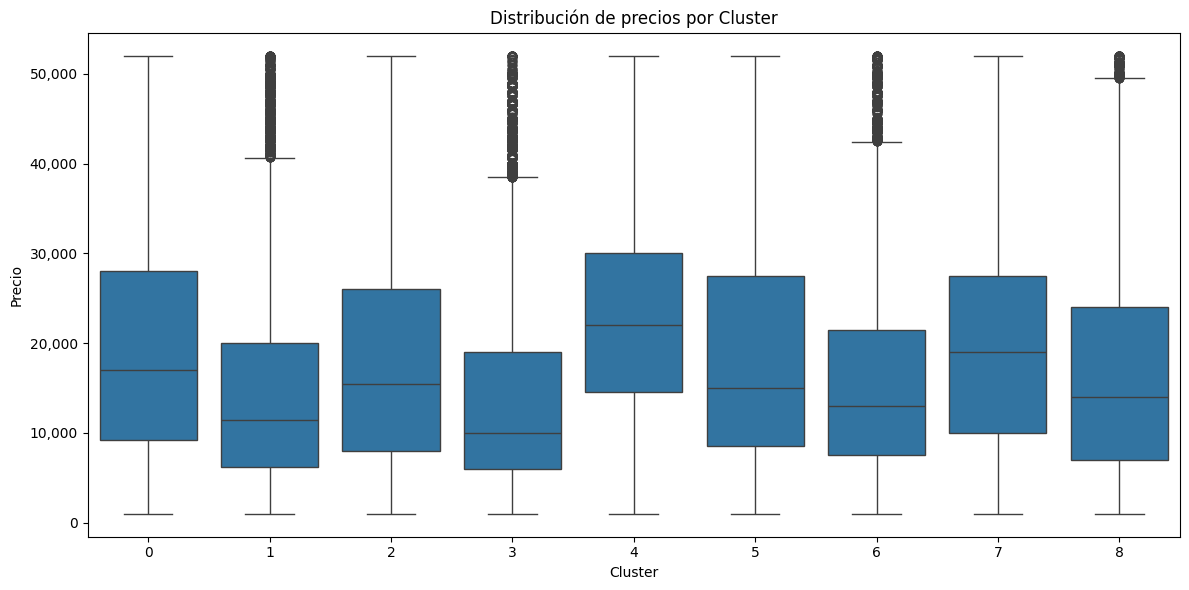

cluster
1    55686
3    52635
8    40840
2    38919
6    33027
5    15445
0    10671
4     2743
7     1808
Name: count, dtype: int64


In [76]:
# Analizamos distribucion de precios por Clusters geograficos
df_cluster_9 = pd.read_csv('c://users//Sergi//proyectos//proyecto_final//data//processed//archivo_cluster_KMeans_9.csv')

# Creamos el gráfico
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='price', data = df_cluster_9)

# Configuramos el gráfico
plt.title('Distribución de precios por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Precio')

# Rotamos las etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=0)

# Ajustamos el formato de los valores del eje y para mostrar miles con coma
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Ajustamos los márgenes
plt.tight_layout()

# Mostramos el gráfico
plt.show()

print(df_cluster_9['cluster'].value_counts())

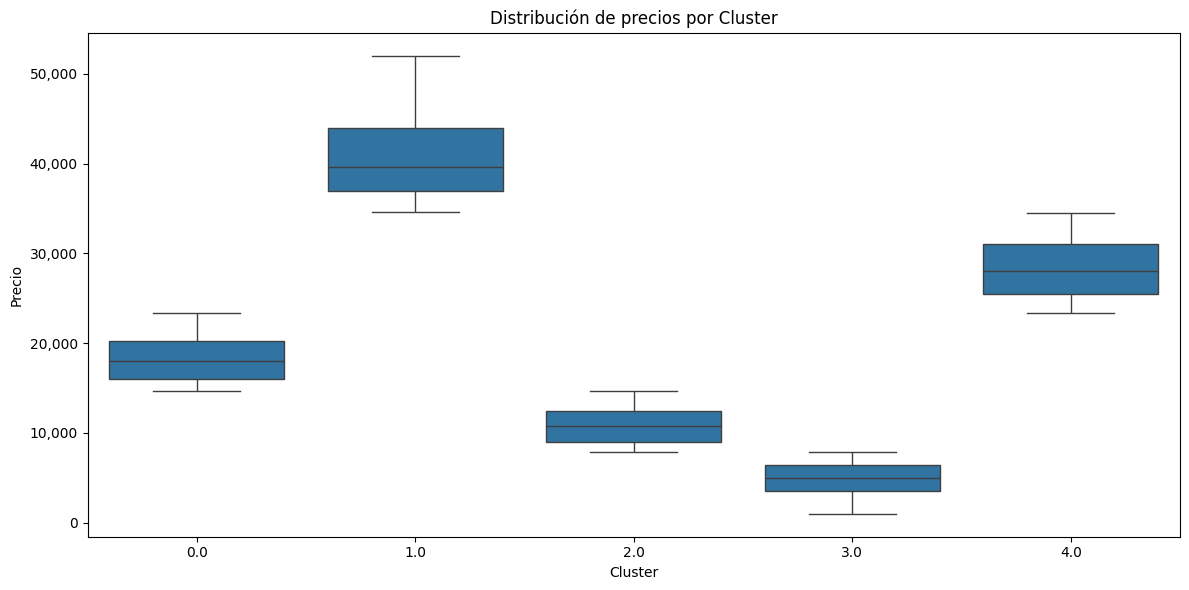

cluster
3.0    58170
2.0    53261
0.0    41828
4.0    29617
1.0    18543
Name: count, dtype: int64


In [3]:
# Analizamos distribucion de precios por cluster Geograficos - Precio - Fabricante
df_cluster_5 = pd.read_csv('c://users//Sergi//proyectos//proyecto_final//data//processed//archivo_cluster_KMeans_5.csv')

# Creamos el gráfico
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='price', data = df_cluster_5)

# Configuramos el gráfico
plt.title('Distribución de precios por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Precio')

# Rotamos las etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=0)

# Ajustamos el formato de los valores del eje y para mostrar miles con coma
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Ajustamos los márgenes
plt.tight_layout()

# Mostramos el gráfico
plt.show()

print(df_cluster_5['cluster'].value_counts())

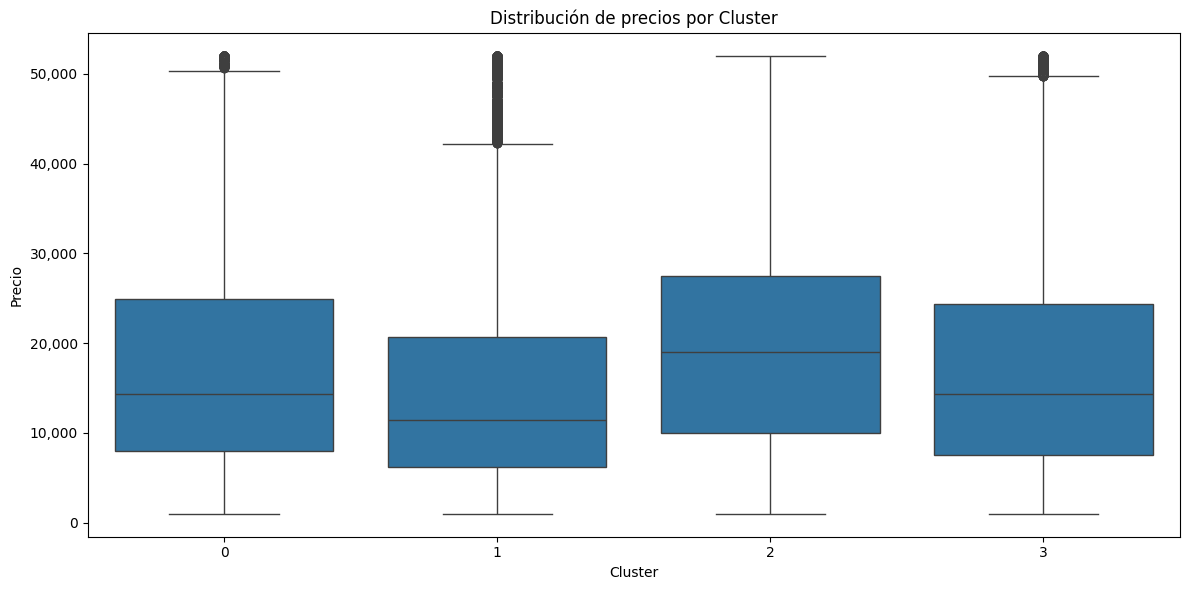

cluster
1    125785
3     62695
0     61484
2      1810
Name: count, dtype: int64


In [4]:
df_cluster_4 = pd.read_csv('c://users//Sergi//proyectos//proyecto_final//data//processed//archivo_cluster_KMeans_4.csv')

# Creamos el gráfico
plt.figure(figsize=(12, 6))
sns.boxplot(x='cluster', y='price', data = df_cluster_4)

# Configuramos el gráfico
plt.title('Distribución de precios por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Precio')

# Rotamos las etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=0)

# Ajustamos el formato de los valores del eje y para mostrar miles con coma
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Ajustamos los márgenes
plt.tight_layout()

# Mostramos el gráfico
plt.show()

print(df_cluster_4['cluster'].value_counts())


In [51]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Leer el archivo CSV
df_cluster_5 = pd.read_csv('c://users//Sergi//proyectos//proyecto_final//data//processed//archivo_cluster_KMeans_5.csv')

# Eliminar las columnas 'lat' y 'long'
df_cluster_5 = df_cluster_5.drop(['lat', 'long'], axis=1)

# Eliminar los registros que no tienen cluster asignado
df_cluster_5 = df_cluster_5.dropna(subset=['cluster']).reset_index(drop=True)

# Eliminar las filas donde 'cluster' es 0, 2, 3 o 4
df_cluster_5 = df_cluster_5[~df_cluster_5['cluster'].isin([0, 2, 3, 4])].reset_index(drop=True)

# Verificar la cantidad de nulos en el DataFrame
nulos = df_cluster_5.isnull().sum()
print(nulos)

# Separar la columna 'price'
prices = df_cluster_5['price'].copy()

# Columnas no numéricas y numéricas (excluyendo 'price')
columnas_nn = ['manufacturer', 'model', 'fuel', 'transmission', 'drive', 'size', 'type', 'state']
num_variables = df_cluster_5.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_variables.remove('cluster')  # Asumiendo que 'cluster' no debe ser escalado
num_variables.remove('price')    # Excluir 'price' del escalado

# Crear el preprocesador para las columnas no numéricas
preprocessor_cat = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), columnas_nn)
    ],
    remainder='passthrough'
)

# Crear el pipeline para escalar las columnas
pipeline = Pipeline(steps=[
    ('cat_preprocessor', preprocessor_cat),
    ('scaler', MinMaxScaler())
])

# Aplicar el pipeline al DataFrame sin la columna 'price'
df_cluster_5_features = df_cluster_5.drop(columns=['price'])
df_cluster_5_preprocessed = pipeline.fit_transform(df_cluster_5_features)

# Crear un nuevo DataFrame con las columnas escaladas y mantener 'price' sin cambios
df_escalado = pd.DataFrame(df_cluster_5_preprocessed, columns=num_variables + columnas_nn + ['cluster'])
df_escalado['price'] = prices.values

# Asegurar que los índices coincidan
df_escalado = df_escalado.reset_index(drop=True)
df_escalado['price'] = prices.reset_index(drop=True)

# Eliminar la columna 'cluster' ya que no se usará en el modelo
df_escalado = df_escalado.drop(['cluster'], axis=1)

# Separar características (X) y la variable objetivo (y)
X = df_escalado.drop(['price'], axis=1)
y = df_escalado['price']

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar las formas de los conjuntos de entrenamiento y prueba
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


price           0
year            0
manufacturer    0
model           0
fuel            0
odometer        0
transmission    0
drive           0
size            0
type            0
state           0
cluster         0
dtype: int64
(14834, 10) (3709, 10) (14834,) (3709,)


In [52]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np


# Lista de modelos de regresión
regression_models = [
    GradientBoostingRegressor(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    KNeighborsRegressor(),
    Lasso(max_iter=10000),
    SGDRegressor(max_iter=10000),
    XGBRegressor()
]

# Entrenar y evaluar los modelos de regresión
print("Modelos de Regresión:")
for model in regression_models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"{type(model).__name__} R2 Score: {r2:.2f}")
    print(f"{type(model).__name__} RMSE: {rmse:.2f}")


Modelos de Regresión:
GradientBoostingRegressor R2 Score: 0.33
GradientBoostingRegressor RMSE: 3860.13
DecisionTreeRegressor R2 Score: 0.49
DecisionTreeRegressor RMSE: 3390.63
RandomForestRegressor R2 Score: 0.71
RandomForestRegressor RMSE: 2546.05
KNeighborsRegressor R2 Score: 0.46
KNeighborsRegressor RMSE: 3487.03
Lasso R2 Score: 0.12
Lasso RMSE: 4432.24
SGDRegressor R2 Score: 0.12
SGDRegressor RMSE: 4439.03
XGBRegressor R2 Score: 0.62
XGBRegressor RMSE: 2922.43


In [53]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_squared_error

# Definir el modelo
xgb = XGBRegressor()

# Definir la cuadrícula de hiperparámetros a buscar
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Definir el método de evaluación
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring=scorer, cv=3, verbose=1, n_jobs=-1)

# Ajustar el GridSearchCV al conjunto de entrenamiento
grid_search.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

# Evaluar el mejor modelo en el conjunto de prueba
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = best_xgb.score(X_test, y_test)

print(f"Best XGBRegressor R2 Score: {r2:.2f}")
print(f"Best XGBRegressor RMSE: {rmse:.2f}")


Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Mejores hiperparámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 1.0}
Best XGBRegressor R2 Score: 0.65
Best XGBRegressor RMSE: 2786.50


In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np

# Definir el modelo
rf = RandomForestRegressor(random_state=42)

# Definir la cuadrícula de hiperparámetros a buscar
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Definir el método de evaluación
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Crear el objeto GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, scoring=scorer, cv=3, verbose=1, n_jobs=-1)

# Ajustar el GridSearchCV al conjunto de entrenamiento
grid_search_rf.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search_rf.best_params_)

# Evaluar el mejor modelo en el conjunto de prueba
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = best_rf.score(X_test, y_test)

print(f"Best RandomForestRegressor R2 Score: {r2_rf:.2f}")
print(f"Best RandomForestRegressor RMSE: {rmse_rf:.2f}")


Fitting 3 folds for each of 216 candidates, totalling 648 fits


c:\Users\sergi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
324 fits failed out of a total of 648.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
181 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\sergi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\sergi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\sergi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base

Mejores hiperparámetros: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best RandomForestRegressor R2 Score: 0.72
Best RandomForestRegressor RMSE: 2511.02
